Grover's Search Benchmark Program - Braket
... execution starting at Sep 20, 2024 03:50:15 UTC
************
Executing [3] circuits with num_qubits = 2
Average Circuit Algorithmic Depth, ξ (xi) for the 2 qubit group = 16, 0
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 2 qubit group = 16, 0, 0
Average Creation, Elapsed, Execution Time for the 2 qubit group = 0.004, 0.036, 0.036 secs
Average Hellinger, Normalized Fidelity for the 2 qubit group = 0.804, 0.738

************
Executing [3] circuits with num_qubits = 3
Average Circuit Algorithmic Depth, ξ (xi) for the 3 qubit group = 45, 0
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 3 qubit group = 45, 0, 0
Average Creation, Elapsed, Execution Time for the 3 qubit group = 0.002, 0.042, 0.042 secs
Average Hellinger, Normalized Fidelity for the 3 qubit group = 0.997, 0.995

************
Executing [3] circuits with num_qubits = 4
Average Circuit Algorithmic Depth, ξ (xi) for the 4 qubit group = 117, 0
Average No

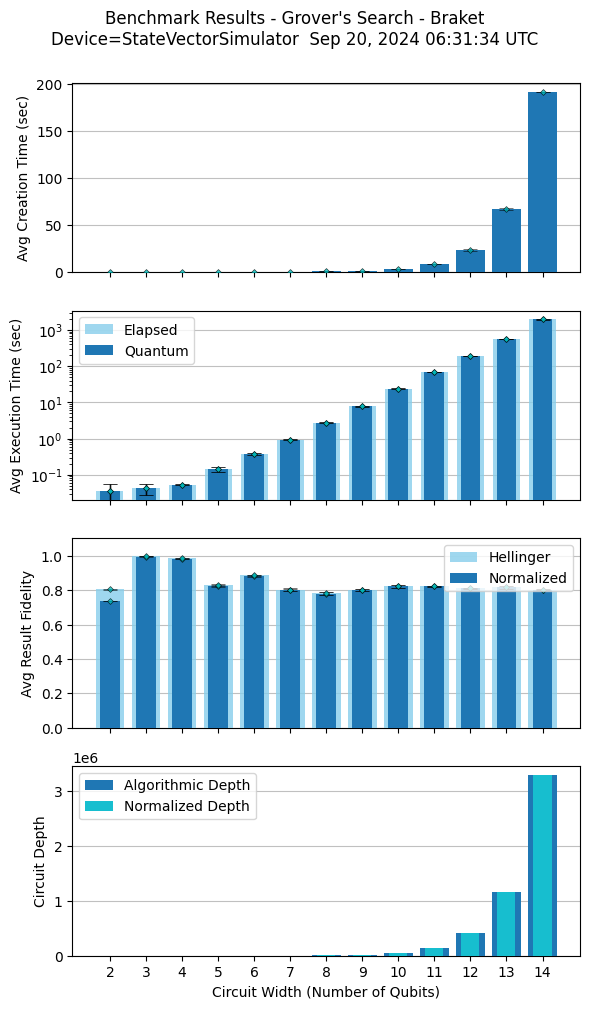

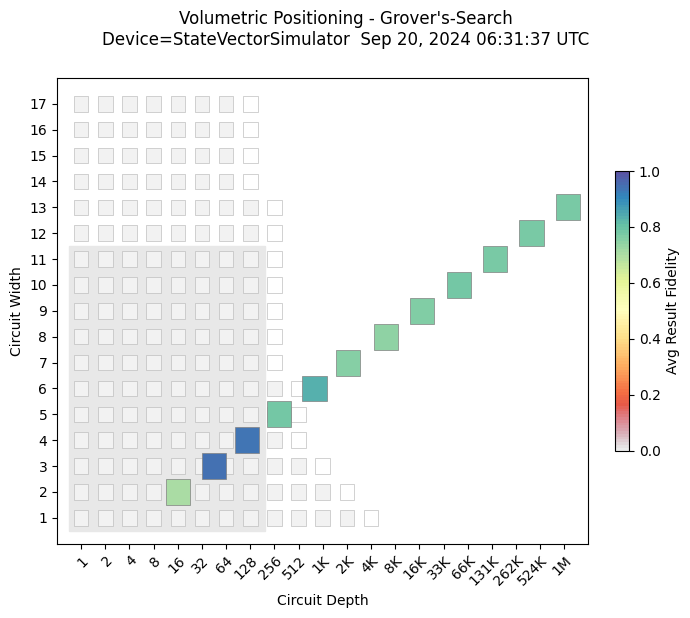

In [1]:
"""
Grover's Search Benchmark Program - Braket
"""

import sys
import time

from braket.circuits import Circuit  # AWS imports: Import Braket SDK modules
import numpy as np

sys.path[1:1] = [ "_common", "_common/braket" ]
sys.path[1:1] = [ "../../_common", "../../_common/braket" ]
import execute as ex
import metrics as metrics

np.random.seed(0)

verbose = False

# saved circuits for display
QC_ = None
grover_oracle = None
diffusion_operator = None
  
# On Braket some devices don't support cu1 (cphaseshift)  
_use_cu1_shim = False

############### Circuit Definition

def GroversSearch(num_qubits, marked_item, n_iterations):
    # allocate qubits
    num_qubits = num_qubits

    # allocate circuit
    qc = Circuit()

    # Start with Hadamard on all qubits
    for i_qubit in range(num_qubits):
        qc.h(i_qubit)

    # loop over the estimated number of iterations
    for _ in range(n_iterations):

        #qc.barrier()
    
        # add the grover oracle
        grover_oracle =create_grover_oracle(num_qubits, marked_item)
        qc.add(grover_oracle)

        # add the diffusion operator
        diffusion_operator =create_diffusion_operator(num_qubits)
        qc.add(diffusion_operator)

    # save smaller circuit example for display
    global QC_    
    if QC_ == None or num_qubits <= 5:
        if num_qubits < 9: QC_ = qc
        
    # return a handle on the circuit
    return qc

############## Grover Oracle

def create_grover_oracle(num_qubits, marked_item):
    global grover_oracle
    marked_item_bits = format(marked_item, f"0{num_qubits}b")[::-1]

    qc = Circuit()

    for (q, bit) in enumerate(marked_item_bits):
        if not int(bit):
            qc.x(q)

    qc.h(num_qubits - 1)
    
    #qc.mcx([x for x in range(num_qubits - 1)], num_qubits - 1)
    add_mcx(qc, [x for x in range(num_qubits - 1)], num_qubits - 1)
    
    qc.h(num_qubits - 1)

    for (q, bit) in enumerate(marked_item_bits):
        if not int(bit):
            qc.x(q)

    if grover_oracle == None or num_qubits <= 5:
        if num_qubits < 9: grover_oracle = qc

    # qc = braket_utils.to_gate(num_qubits=num_qubits, circ=qc, name="Grover")

    return qc

############## Grover Diffusion Operator

def create_diffusion_operator(num_qubits):
    global diffusion_operator
    qc = Circuit()

    for i_qubit in range(num_qubits):
        qc.h(i_qubit)
    for i_qubit in range(num_qubits):
        qc.x(i_qubit)
    qc.h(num_qubits - 1)
    
    #qc.mcx([x for x in range(num_qubits - 1)], num_qubits - 1)
    add_mcx(qc, [x for x in range(num_qubits - 1)], num_qubits - 1)
    
    qc.h(num_qubits - 1)
    for i_qubit in range(num_qubits):
        qc.x(i_qubit)
    for i_qubit in range(num_qubits):
        qc.h(i_qubit)
    
    if diffusion_operator == None or num_qubits <= 5:
        if num_qubits < 9: diffusion_operator = qc

    #qc = braket_utils.to_gate(num_qubits=num_qubits, circ=qc, name="Diffuser")

    return qc

############### MCX shim

# single cx / cu1 unit for mcx implementation
def add_cx_unit(qc, cxcu1_unit, controls, target):
    num_controls = len(controls)
    i_qubit = cxcu1_unit[1]
    j_qubit = cxcu1_unit[0]
    theta = cxcu1_unit[2]
    
    if j_qubit != None:
        qc.cnot(controls[j_qubit], controls[i_qubit]) 
        
    #qc.cu1(theta, controls[i_qubit], target)
    if _use_cu1_shim:
        add_cphaseshift(qc, controls[i_qubit], target, theta)
    else:
        qc.cphaseshift(controls[i_qubit], target, theta)
    
    i_qubit = i_qubit - 1
    if j_qubit == None:
        j_qubit = i_qubit + 1
    else:
        j_qubit = j_qubit - 1
        
    if theta < 0:
        theta = -theta
    
    new_units = []
    if i_qubit >= 0:
        new_units += [ [ j_qubit, i_qubit, -theta ] ]
        new_units += [ [ num_controls - 1, i_qubit, theta ] ]
        
    return new_units

# mcx recursion loop 
def add_cxcu1_units(qc, cxcu1_units, controls, target):
    new_units = []
    for cxcu1_unit in cxcu1_units:
        new_units += add_cx_unit(qc, cxcu1_unit, controls, target)
    cxcu1_units.clear()
    return new_units

# mcx gate implementation: brute force and inefficient
# start with a single CU1 on last control and target
# and recursively expand for each additional control
def add_mcx(qc, controls, target):
    num_controls = len(controls)
    theta = np.pi / 2**num_controls
    qc.h(target)
    cxcu1_units = [ [ None, num_controls - 1, theta] ]
    while len(cxcu1_units) > 0:
        cxcu1_units += add_cxcu1_units(qc, cxcu1_units, controls, target)
    qc.h(target)
 
############### CPHASESHIFT shim 

# a CU1 or CPHASESHIFT equivalent
def add_cphaseshift(qc, control, target, theta):
    qc.rz(control, theta/2)
    qc.cnot(control, target)
    qc.rz(target, -theta/2)
    qc.cnot(control, target)
    qc.rz(target, theta/2)
    
    
############### Analysis
            
# Analyze and print measured results
# Expected result is always the secret_int, so fidelity calc is simple
def analyze_and_print_result(qc, result, num_qubits, marked_item):
    
    # obtain shots from the result metadata
    num_shots = result.task_metadata.shots
    
    # obtain counts from the result object
    counts_r = result.measurement_counts
    
    # obtain counts from the result object
    # for braket, need to reverse the key to match binary order
    # for braket, measures all qubits, so we have to remove data qubit measurement
    counts_r = result.measurement_counts
    counts = {}
    for measurement_r in counts_r.keys():
        measurement = measurement_r[::-1] # reverse order
        counts[measurement] = counts_r[measurement_r]
    if verbose: print(f"For type {marked_item} measured: {counts}")    

    # we compare counts to analytical correct distribution
    correct_dist = grovers_dist(num_qubits, marked_item)
    if verbose: print(f"Marked item: {marked_item}, Correct dist: {correct_dist}")

    # use our polarization fidelity rescaling
    fidelity = metrics.polarization_fidelity(counts, correct_dist)

    return counts, fidelity

def grovers_dist(num_qubits, marked_item):
    
    n_iterations = int(np.pi * np.sqrt(2 ** num_qubits) / 4)
    
    dist = {}

    for i in range(2**num_qubits):
        key = bin(i)[2:].zfill(num_qubits)
        theta = np.arcsin(1/np.sqrt(2 ** num_qubits))
        
        if i == int(marked_item):
            dist[key] = np.sin((2*n_iterations+1)*theta)**2
        else:
            dist[key] = (np.cos((2*n_iterations+1)*theta)/(np.sqrt(2 ** num_qubits - 1)))**2
    return dist


################ Benchmark Loop

# Execute program with default parameters
def run (min_qubits=2, max_qubits = 14, max_circuits = 3, num_shots = 1000,
        backend_id = 'simulator',
        use_cu1_shim=False):

    print("Grover's Search Benchmark Program - Braket")

    # validate parameters (smallest circuit is 2 qubits)
    max_qubits = max(2, max_qubits)
    min_qubits = min(max(2, min_qubits), max_qubits)
    #print(f"min, max qubits = {min_qubits} {max_qubits}")
    
    # set the flag to use a cu1 (cphaseshift) shim if given, or for devices that don't support it
    global _use_cu1_shim
    if "ionq/" in backend_id: use_cu1_shim=True
    _use_cu1_shim = use_cu1_shim
    if _use_cu1_shim:
        print("... using CPHASESHIFT shim")
        
    # Initialize metrics module
    metrics.init_metrics()

    # Define custom result handler
    def execution_handler(qc, result, num_qubits, s_int):

        # determine fidelity of result set
        num_qubits = int(num_qubits)
        counts, fidelity = analyze_and_print_result(qc, result, num_qubits, int(s_int))
        metrics.store_metric(num_qubits, s_int, 'fidelity', fidelity)

    # Initialize execution module using the execution result handler above and specified backend_id
    ex.init_execution(execution_handler)
    ex.set_execution_target(backend_id)

    # Execute Benchmark Program N times for multiple circuit sizes
    # Accumulate metrics asynchronously as circuits complete
    for num_qubits in range(min_qubits, max_qubits + 1):

        # determine number of circuits to execute for this group
        num_circuits = min(2 ** (num_qubits), max_circuits)

        print(f"************\nExecuting [{num_circuits}] circuits with num_qubits = {num_qubits}")
        
        # determine range of secret strings to loop over
        if 2**(num_qubits) <= max_circuits:
            s_range = list(range(num_circuits))
        else:
            s_range = np.random.choice(2**(num_qubits), num_circuits, False)
        
        # loop over limited # of secret strings for this
        for s_int in s_range:
            # create the circuit for given qubit size and secret string, store time metric
            ts = time.time()

            n_iterations = int(np.pi * np.sqrt(2 ** num_qubits) / 4)

            qc = GroversSearch(num_qubits, s_int, n_iterations)
            metrics.store_metric(num_qubits, s_int, 'create_time', time.time() - ts)

            # submit circuit for execution on target (simulator, cloud simulator, or hardware)
            ex.submit_circuit(qc, num_qubits, s_int, shots=num_shots)

        # execute all circuits for this group, aggregate and report metrics when complete
        ex.execute_circuits()
        metrics.aggregate_metrics_for_group(num_qubits)
        metrics.report_metrics_for_group(num_qubits)

    # Alternatively, execute all circuits, aggregate and report metrics
    # ex.execute_circuits()
    # metrics.aggregate_metrics_for_group(num_qubits)
    # metrics.report_metrics_for_group(num_qubits)
    
    # print a sample circuit created (if not too large)
    print("Sample Circuit:"); print(QC_ if QC_ != None else "  ... too large!")
    print("\nOracle ="); print(grover_oracle)
    print("\nDiffuser ="); print(diffusion_operator)

    # Plot metrics for all circuit sizes
    metrics.plot_metrics("Benchmark Results - Grover's Search - Braket")


# if main, execute method
if __name__ == '__main__': run()
